In [1]:
import sys, os
import importlib
from importlib import reload

import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy
import tqdm
import joblib

import ROOT

from simhelper import root

Welcome to JupyROOT 6.28/10


In [5]:
data_dir = "/home/tomren/geant_projects/musim_test"
fname_bkg = f"{data_dir}/cosmic_all/run_1_digi_recon.root"
fname_sig = f"{data_dir}/llp_hxx_bb/run_25_digi_cosmic_recon_skim.root"

## Open Background file
fbkg = ROOT.TFile(fname_bkg)
tree_bkg = fbkg.Get("data")
entries = tree_bkg.GetEntries()
branches = [b.GetName() for b in tree_bkg.GetListOfBranches()]
print("Entries", entries)
print("Branches", branches)

## Open Signal file
fsig = ROOT.TFile(fname_sig)
tree_sig = fsig.Get("data")
entries = tree_sig.GetEntries()
branches = [b.GetName() for b in tree_sig.GetListOfBranches()]
print("Entries", entries)
print("Branches", branches)

Entries 218543
Branches ['SimEntry', 'Track_x0', 'Track_y0', 'Track_z0', 'Track_t0', 'Track_kx', 'Track_ky', 'Track_kz', 'Track_kt', 'Track_cov', 'Track_chi2', 'Track_id', 'Track_iv_ind', 'Track_iv_err', 'Track_digiInds', 'Vertex_x0', 'Vertex_y0', 'Vertex_z0', 'Vertex_t0', 'Vertex_cov', 'Vertex_chi2', 'Vertex_id', 'Vertex_trackInds', 'Vertex_tracklet_n0', 'Vertex_tracklet_n2', 'Vertex_tracklet_n3', 'Vertex_tracklet_n4p', 'Digi_x', 'Digi_y', 'Digi_z', 'Digi_t', 'Digi_edep', 'Digi_trackID', 'Digi_pdgID', 'Digi_detectorID', 'Digi_type', 'Digi_hitInds', 'Digi_direction', 'Run_number', 'Evt_number', 'Seed_0', 'Seed_1', 'Hit_x', 'Hit_y', 'Hit_z', 'Hit_t', 'Hit_edep', 'Hit_px', 'Hit_py', 'Hit_pz', 'Hit_trackID', 'Hit_trackIDparent', 'Hit_pdgID', 'Hit_pdgIDparent', 'Hit_isprimary', 'Hit_processID', 'Hit_detectorID', 'Gen_x', 'Gen_y', 'Gen_z', 'Gen_t', 'Gen_px', 'Gen_py', 'Gen_pz', 'Gen_pdgID', 'Gen_index', 'Step_x', 'Step_y', 'Step_z', 'Step_t', 'Step_edep', 'Step_px', 'Step_py', 'Step_pz', 'S

In [6]:
def process_trigger(file, entries=-1):
    # Get metadata
    # file.get_tree("metadata_digi")
    # metadata_digi = file.get_entry(0)
    
    # Get data
    file.get_tree("data;1")
    print("Entries", file.entries)


    # Make a container
    keys = ["event_idx", "n_hits", "n_hitslayer", "n_hitsquarterlayer", "n_hitstower", "n_hitstower_2", "n_tracks", "n_tracks_tower", "time_diff", "n_seeds", "seed_delta_t", "seed_"]
    data = {key:[] for key in keys}

    if entries==-1:
        entries = file.entries    
    entries = min(entries, file.entries )
    
    for i in tqdm.tqdm(range(entries)):
        root_data = file.get_entry(i)
        if len(root_data["Digi_detectorID"])==0:
            continue 
        detids = np.array(root_data["Digi_detectorID"])

        id_layer_group = detids//1_00000
        id_quarterlayer_group = detids//1_00000*1_00000 + detids%1_00000//64 #(900//3.5/8)
        id_tower_group = detids//1_000_00000
        id_detector = detids//1_000_000_00000
        _, unique_layer_counts = np.unique(id_layer_group,return_counts=True)
        _, unique_quarterlayer_counts = np.unique(id_quarterlayer_group,return_counts=True)
        tower_ids, unique_tower_counts = np.unique(id_tower_group,return_counts=True)
        mask_backtracker = (detids%1_000_000_00000)==2
        mask_toptracker = (detids%1_000_000_00000)==1

        tower_most_hits = tower_ids[np.argmax(unique_tower_counts)] if len(unique_tower_counts)>0 else 0

        ## Hits
        data["n_hits"].append(len(root_data["Digi_x"]))
        data["n_hitslayer"].append(max(unique_layer_counts))
        data["n_hitsquarterlayer"].append(max(unique_quarterlayer_counts))
        data["n_hitstower"].append(max(unique_tower_counts))
        nhits_tower_max2 = np.sort(unique_tower_counts)[-2] if len(unique_tower_counts)>1 else max(unique_tower_counts)
        data["n_hitstower_2"].append(nhits_tower_max2)
        ts_top = np.array(root_data["Digi_t"])[(id_tower_group==tower_most_hits)&(id_layer_group%100>=5)]
        ts_bot = np.array(root_data["Digi_t"])[(id_tower_group==tower_most_hits)&(id_layer_group%100<=0)]
        data["time_diff"].append(np.mean(ts_top)-np.mean(ts_bot))

        ## Tracks
        track_ids, track_id_counts = np.unique(root_data["Digi_trackID"],return_counts=True)
        mask_track_single_module=[]
        mask_track_4_hits=[]
        for j in track_ids:
            if j<0:
                continue
            hits_tower = id_tower_group[root_data["Digi_trackID"]==j]
            _, counts = np.unique(hits_tower,return_counts=True)
            mask_track_4_hits.append(sum(counts)>=4)
            mask_track_single_module.append(max(counts)>=4)
        # data["n_tracks"].append(sum(track_id_counts>4))
        # print(sum(track_id_counts>=4), sum(mask_track_4_hits),sum(mask_track_single_module))
        data["n_tracks"].append(sum(mask_track_4_hits))
        data["n_tracks_tower"].append(sum(mask_track_single_module))

        ## Seeds
        nseeds=0
        for i in range(len(root_data["Digi_detectorID"])):
            for j in range(i+1, len(root_data["Digi_detectorID"])):
                x,y,z,t = root_data["Digi_x"][i],root_data["Digi_y"][i],root_data["Digi_z"][i],root_data["Digi_t"][i]
                x2,y2,z2,t2 = root_data["Digi_x"][j],root_data["Digi_y"][j],root_data["Digi_z"][j],root_data["Digi_t"][j]
                dr = np.linalg.norm([x2-x,y2-y,z2-z])
                dt = t2-t
                if dt==0:
                    continue
                delta_t = dr/300-abs(dt)
                vz = (z2-z)/dt
                data["seed_delta_t"].append(delta_t)
                if abs(delta_t)<0.5 and vz>100 and dr>2000:
                    nseeds+=1
        data["n_seeds"].append(nseeds)
        
    for key in data:
        data[key]=np.array(data[key])
    return data

In [7]:
fsig1 = root.tfile_reader(fname_sig)
fsig1.get_tree("data")
data_sig = process_trigger(fsig1, entries=1000)

fbkg = root.tfile_reader(fname_bkg)
fbkg.get_tree("data")
data_bkg = process_trigger(fbkg)

Entries 9172


/home/tomren/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice./s]
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/tomren/.local/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:32<00:00, 30.55it/s]


Entries 218543


100%|█████████████████████████████████████████████████████████████████████████| 218543/218543 [02:14<00:00, 1622.12it/s]


# Signal

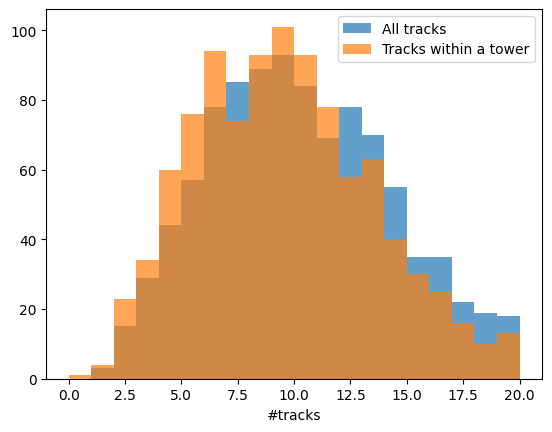

Fraction of bar assembly with >16 digits: 0.182
Fraction of layer with >32 digits: 0.124
Fraction of tower with >54 digits: 0.117


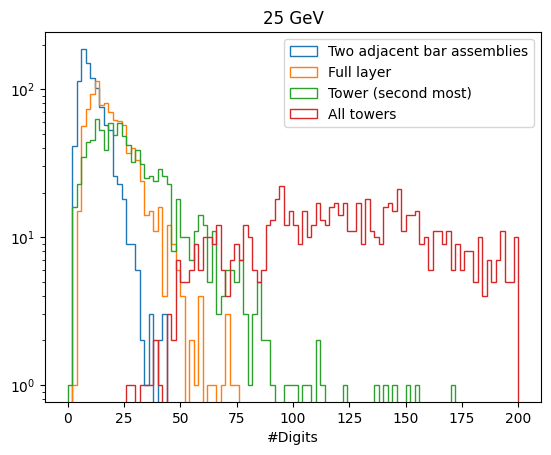

Avg n hits 146.235


In [8]:
data =  data_sig

bins=np.linspace(0,20,21)
plt.hist(data["n_tracks"], bins=bins, alpha=0.7, label="All tracks");
plt.hist(data["n_tracks_tower"], bins=bins, alpha=0.7, label="Tracks within a tower");
plt.xlabel("#tracks")
plt.legend()
plt.show()

plt.hist(data["n_hitsquarterlayer"],bins=100, range=(0,200),histtype="step", label="Two adjacent bar assemblies");
plt.hist(data["n_hitslayer"],bins=100, range=(0,200),histtype="step", label="Full layer");
# plt.hist(data["n_hitstower"],bins=100, range=(0,200),histtype="step", label="tower (6layers)");
plt.hist(data["n_hitstower_2"],bins=100, range=(0,200),histtype="step", label="Tower (second most)");
plt.hist(data["n_hits"],bins=100, range=(0,200),histtype="step", label="All towers");
plt.yscale("log")
plt.title(f"25 GeV")
plt.xlabel("#Digits")
plt.legend()
print("Fraction of bar assembly with >16 digits:", sum(np.array(data["n_hitsquarterlayer"])>16)/len(data["n_hitslayer"]))
print("Fraction of layer with >32 digits:", sum(np.array(data["n_hitslayer"])>32)/len(data["n_hitslayer"]))
print("Fraction of tower with >54 digits:", sum(np.array(data["n_hitstower_2"])>54)/len(data["n_hitslayer"]))
plt.show()

print("Avg n hits", np.mean(data["n_hits"]))

## Signal vs background

### Average time of hits in top/bottom layer

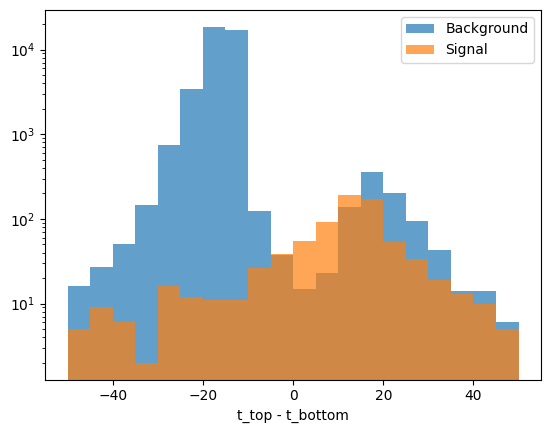

In [117]:
bins=np.linspace(-50,50,21)

plt.hist(data_bkg["time_diff"], bins=bins, alpha=0.7, label="Background");
plt.hist(data_sig["time_diff"], bins=bins, alpha=0.7, label="Signal");
plt.xlabel("t_top - t_bottom [ns]")
plt.legend()
plt.yscale("log")

## Number of hits

# background events: 239
signal efficiency: 0.977


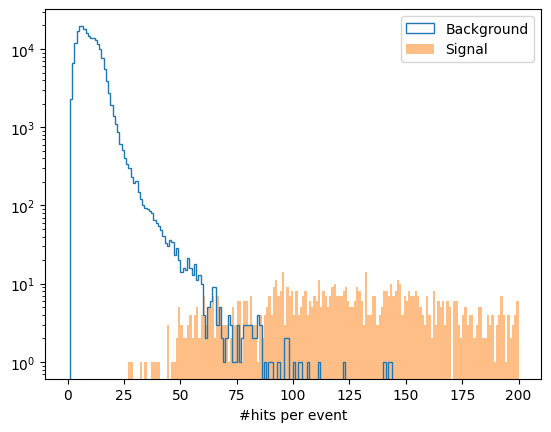

In [16]:
plt.hist(data_bkg["n_hits"], bins=200, range=(0,200), label="Background", alpha=1, color="C0", histtype="step");
plt.hist(data_sig["n_hits"], bins=200, range=(0,200), alpha=0.5, label="Signal", color="C1");
plt.yscale("log")
plt.xlabel("#hits per event")
plt.legend()

threshold_hits = 50
mask1_bkg = data_bkg["n_hits"]>threshold_hits
mask1_sig = data_sig["n_hits"]>threshold_hits
print("# background events:", sum(mask1_bkg))
print("signal efficiency:", sum(mask1_sig)/len(data_sig["n_hits"]))

## Number of 'seeds'
n_seeds: number of hit pairs that are    
* upward (vz > 100 mm/ns)
* seperated by at least 2m in space
* |dr/c - dt|<0.5ns

# background events: 5
signal efficiency: 0.972

 Combined cuts:
# background events: 4
signal efficiency: 0.96


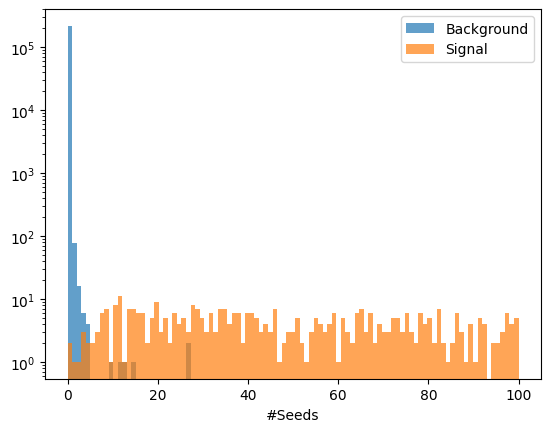

In [23]:
bins=np.linspace(0,100,100)

plt.hist(data_bkg["n_seeds"], bins=bins, alpha=0.7, label="Background");
plt.hist(data_sig["n_seeds"], bins=bins, alpha=0.7, label="Signal");
plt.xlabel("#Seeds")
plt.legend()
plt.yscale("log")

threshold_hits = 10
mask2_bkg = data_bkg["n_seeds"]>threshold_hits
mask2_sig = data_sig["n_seeds"]>threshold_hits
print("# background events:", sum(mask2_bkg))
print("signal efficiency:", sum(mask2_sig)/len(data_sig["n_hits"]))

print("\n Combined cuts:")

print("# background events:", sum(mask1_bkg&mask2_bkg))
print("signal efficiency:", sum(mask1_sig&mask2_sig)/len(data_sig["n_hits"]))

(-350.0, 350.0)

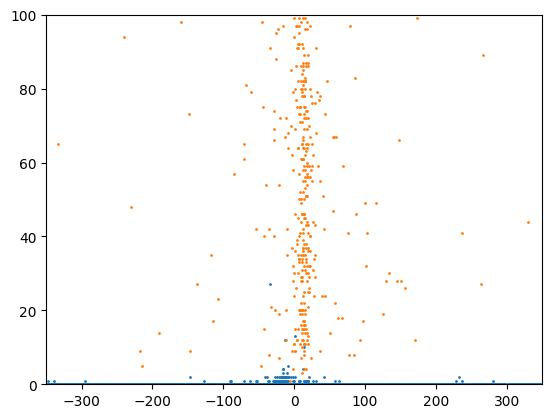

In [26]:
plt.scatter(data_bkg["time_diff"], data_bkg["n_seeds"], s=1, label="Background");
plt.scatter(data_sig["time_diff"], data_sig["n_seeds"], s=1, label="Background");
plt.ylim(0,100)
plt.xlim(-350,350)